In [183]:
batch_size = 64
ncomps = 500
crop_size = 180

In [184]:

import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from monai.data import DataLoader
from monai.transforms import Compose, NormalizeIntensity, ToTensor
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

import torchvision.transforms.functional as F

In [185]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')
exp_name = 'no_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/exp_name/'train'

test_csv_path = macaw_path/'splits'/'test.csv'
test_img_path = macaw_path/exp_name/'test'
# 
kpca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
test_path = macaw_path/exp_name/f'test_hc_data_PCA_{ncomps}.pkl'

In [186]:
home_dir = './'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(os.path.join(home_dir, "splits/train.csv"))
df_val = pd.read_csv(os.path.join(home_dir, "splits/val.csv"))

train_fpaths = [os.path.join(working_dir, "train", filename.replace(".nii.gz", ".tiff")) for filename in df_train['filename']]
train_class_label = df_train['class_label']

# val_fpaths = [os.path.join(working_dir, "val", filename.replace(".nii.gz", ".tiff")) for filename in df_val['filename']]
# val_class_label = df_val['class_label']

In [187]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [188]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [189]:
from utils.datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

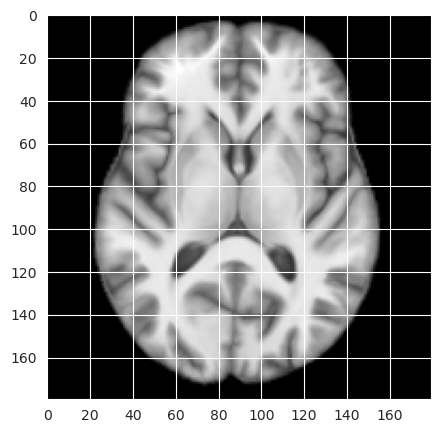

In [190]:
plt.imshow(next(iter(train_loader))[2][1], cmap='gray')

In [191]:
next(iter(train_loader))[0]

tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1])

In [192]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

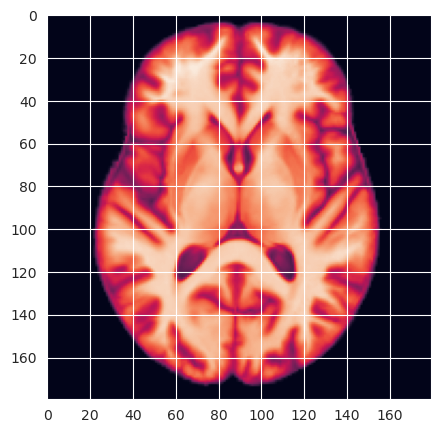

In [193]:
plt.imshow(imgs[0].reshape(crop_size,crop_size))

## Dimensionality reduction

In [194]:
import pickle
from sklearn.decomposition import PCA

# if os.path.exists(kpca_path):
#     with open(kpca_path, 'rb') as f:
#         kpca = pickle.load(f)
# else:
pca = PCA(n_components=ncomps)
pca.fit(imgs)

with open(kpca_path, 'wb') as f:
    pickle.dump(pca, f)

In [195]:
disease = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in train_loader],axis=0)

In [196]:
encoded_data = pca.transform(imgs)

In [197]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)

In [198]:
test_ds = EmmaDataset(test_csv_path, test_img_path, transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

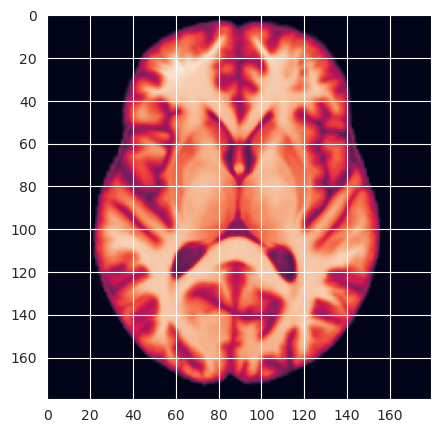

In [199]:
plt.imshow(next(iter(train_loader))[2][1])

In [200]:
test_imgs = np.concatenate([d[2].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

In [201]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

Disease: [1 1 0 1 1]
Bias: [0 0 1 1 1]


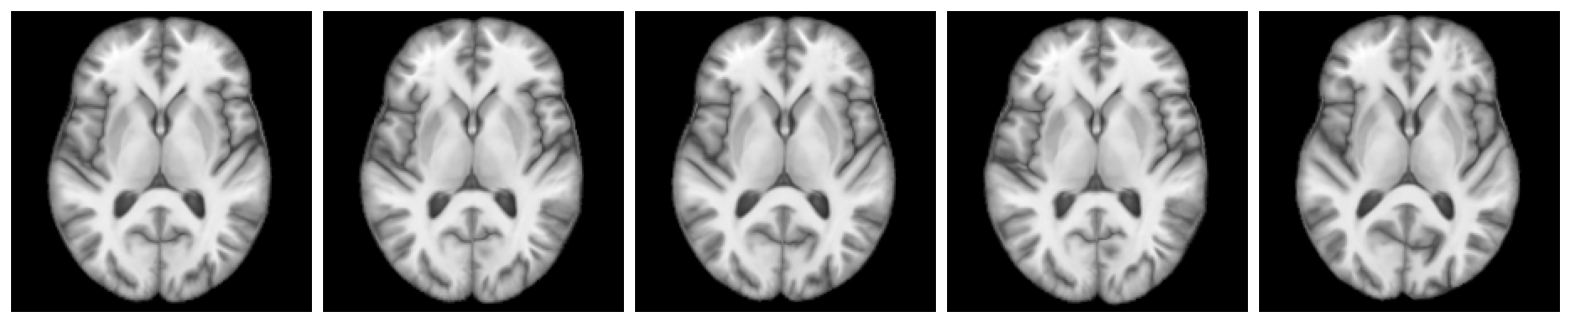

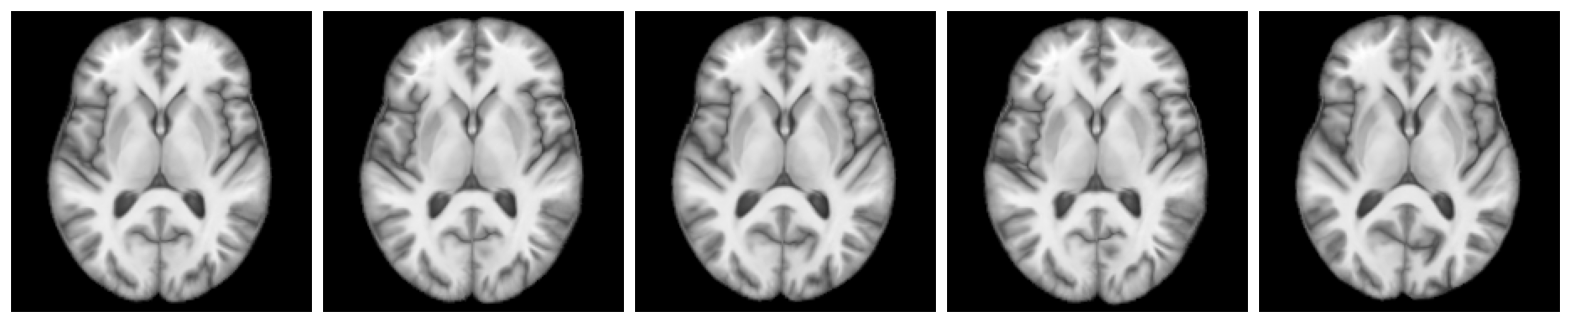

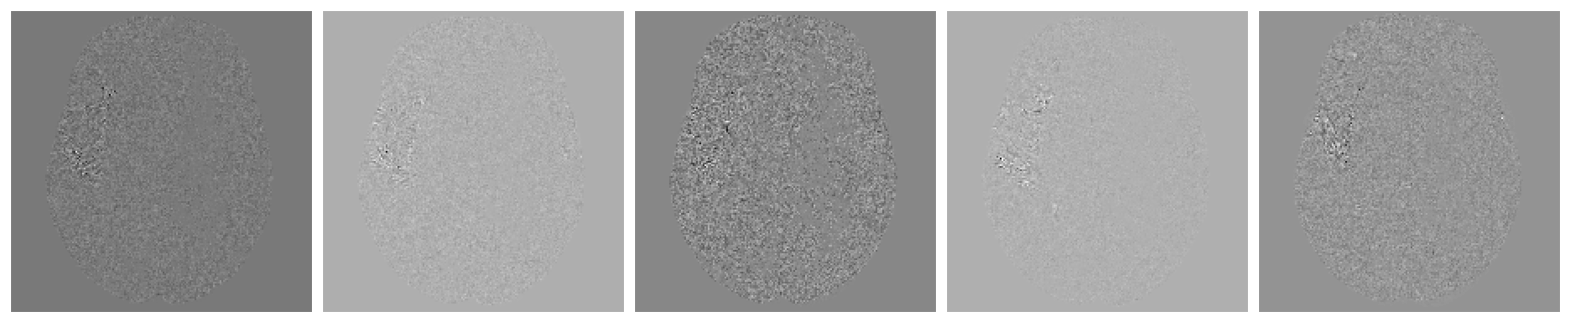

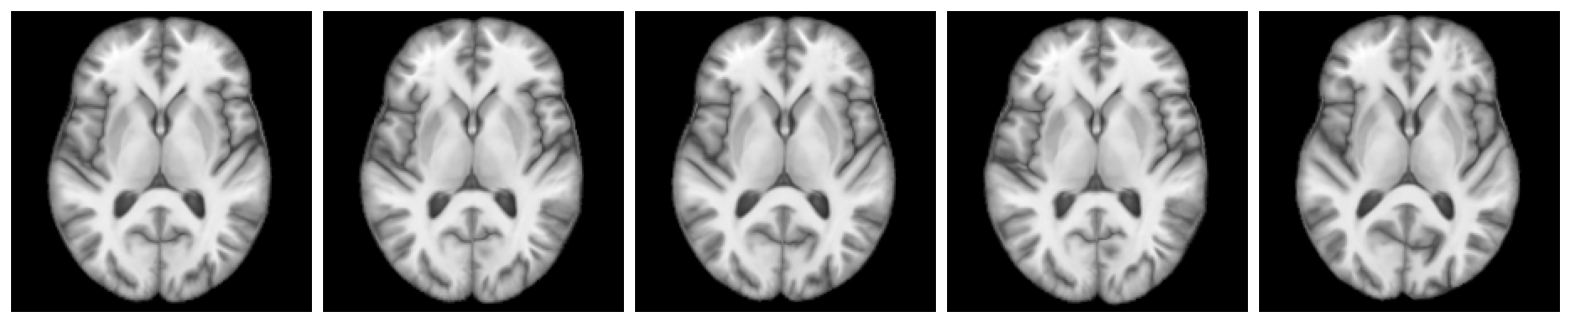

In [202]:
import utils.visualize as vis
print("Disease:", disease[:5])
print("Bias:",bias[:5])

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in diff],cols=5, cmap='gray')
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in rr], clim=(0,1), cols=5)

In [203]:
disease = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in test_loader],axis=0)

In [204]:
np.min(X_recon)

-0.0011791866

In [205]:


# age = np.round(age)
# age-=min_age

encoded_data = pca.transform(test_imgs)

In [206]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)